In [1]:
from datetime import timedelta

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

import parcels

In [11]:
def bickleyjet_fieldset(times, xdim=51, ydim=51):
    """Bickley Jet Field as implemented in Hadjighasem et al 2017,
    10.1063/1.4982720"""
    U0 = 0.06266
    L = 1770.0
    r0 = 6371.0
    k1 = 2 * 1 / r0
    k2 = 2 * 2 / r0
    k3 = 2 * 3 / r0
    eps1 = 0.075
    eps2 = 0.4
    eps3 = 0.3
    c3 = 0.461 * U0
    c2 = 0.205 * U0
    c1 = c3 + ((np.sqrt(5) - 1) / 2.0) * (k2 / k1) * (c2 - c3)

    a, b = np.pi * r0, 7000.0  # domain size
    lon = np.linspace(0, a, xdim, dtype=np.float32)
    lat = np.linspace(-b / 2, b / 2, ydim, dtype=np.float32)
    dx, dy = lon[2] - lon[1], lat[2] - lat[1]

    U = np.zeros((times.size, lat.size, lon.size), dtype=np.float32)
    V = np.zeros((times.size, lat.size, lon.size), dtype=np.float32)
    #P = np.zeros((times.size, lat.size, lon.size), dtype=np.float32)

    for i in range(lon.size):
        for j in range(lat.size):
            x1 = lon[i] - dx / 2
            x2 = lat[j] - dy / 2
            for t in range(len(times)):
                time = times[t]

                f1 = eps1 * np.exp(-1j * k1 * c1 * time)
                f2 = eps2 * np.exp(-1j * k2 * c2 * time)
                f3 = eps3 * np.exp(-1j * k3 * c3 * time)
                F1 = f1 * np.exp(1j * k1 * x1)
                F2 = f2 * np.exp(1j * k2 * x1)
                F3 = f3 * np.exp(1j * k3 * x1)
                G = np.real(np.sum([F1, F2, F3]))
                G_x = np.real(np.sum([1j * k1 * F1, 1j * k2 * F2, 1j * k3 * F3]))
                U[t, j, i] = (
                    U0 / (np.cosh(x2 / L) ** 2)
                    + 2 * U0 * np.sinh(x2 / L) / (np.cosh(x2 / L) ** 3) * G
                )
                V[t, j, i] = U0 * L * (1.0 / np.cosh(x2 / L)) ** 2 * G_x

    data = {"U": U, "V": V}#, "P": P}
    dimensions = {"lon": lon, "lat": lat, "time": times}
    allow_time_extrapolation = True if len(times) == 1 else False
    fieldset = parcels.FieldSet.from_data(
        data, dimensions, mesh="flat", allow_time_extrapolation=allow_time_extrapolation
    )
    fieldset.U.interp_method = "cgrid_velocity"
    fieldset.V.interp_method = "cgrid_velocity"
    return fieldset


fieldsetBJ = bickleyjet_fieldset(times=np.arange(0, 1.1, 0.1) * 86400)

In [12]:
fieldsetBJ.add_constant("halo_west", fieldsetBJ.U.grid.lon[0])
fieldsetBJ.add_constant("halo_east", fieldsetBJ.U.grid.lon[-1])
fieldsetBJ.add_periodic_halo(zonal=True)


def ZonalBC(particle, fieldset, time):
    if particle.lon < fieldset.halo_west:
        particle_dlon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle_dlon -= fieldset.halo_east - fieldset.halo_west

#3D case

In [31]:
def bickleyjet_fieldset_3d(times, xdim=51, ydim=51, zdim=11):
    """A Bickley Jet Field with 3D linear decay based on Hadjighasem et al 2017,
    10.1063/1.4982720"""
    U0 = 0.06266
    L = 1770.0
    r0 = 6371.0
    k1 = 2 * 1 / r0
    k2 = 2 * 2 / r0
    k3 = 2 * 3 / r0
    eps1 = 0.075
    eps2 = 0.4
    eps3 = 0.3
    c3 = 0.461 * U0
    c2 = 0.205 * U0
    c1 = c3 + ((np.sqrt(5) - 1) / 2.0) * (k2 / k1) * (c2 - c3)

    a, b = np.pi * r0, 7000.0  # domain size
    lon = np.linspace(0, a, xdim, dtype=np.float32)
    lat = np.linspace(-b / 2, b / 2, ydim, dtype=np.float32)
    depth = np.linspace(0, 1000, zdim, dtype=np.float32)
    dx, dy = lon[2] - lon[1], lat[2] - lat[1]

    U = np.zeros((times.size, depth.size, lat.size, lon.size), dtype=np.float32)
    V = np.zeros((times.size, depth.size, lat.size, lon.size), dtype=np.float32)
    W = np.zeros((times.size, depth.size, lat.size, lon.size), dtype=np.float32)

    for i in range(lon.size):
        for j in range(lat.size):
            x1 = lon[i] - dx / 2
            x2 = lat[j] - dy / 2
            for t in range(len(times)):
                time = times[t]

                f1 = eps1 * np.exp(-1j * k1 * c1 * time)
                f2 = eps2 * np.exp(-1j * k2 * c2 * time)
                f3 = eps3 * np.exp(-1j * k3 * c3 * time)
                F1 = f1 * np.exp(1j * k1 * x1)
                F2 = f2 * np.exp(1j * k2 * x1)
                F3 = f3 * np.exp(1j * k3 * x1)
                G = np.real(np.sum([F1, F2, F3]))
                G_x = np.real(np.sum([1j * k1 * F1, 1j * k2 * F2, 1j * k3 * F3]))
                U[t, 0, j, i] = (
                    U0 / (np.cosh(x2 / L) ** 2)
                    + 2 * U0 * np.sinh(x2 / L) / (np.cosh(x2 / L) ** 3) * G
                )
                V[t, 0, j, i] = U0 * L * (1.0 / np.cosh(x2 / L)) ** 2 * G_x
    
    for k in range(1, depth.size):
        U[:, k, :, :] = U[:, 0, :, :] * ( (depth.size - k) / depth.size)
        V[:, k, :, :] = V[:, 0, :, :] * ( (depth.size - k) / depth.size)

    data = {"U": U, "V": V, "W": W}
    dimensions = {"lon": lon, "lat": lat, "depth": depth, "time": times}
    allow_time_extrapolation = True if len(times) == 1 else False
    fieldset = parcels.FieldSet.from_data(
        data, dimensions, mesh="flat", allow_time_extrapolation=allow_time_extrapolation
    )
    fieldset.U.interp_method = "cgrid_velocity"
    fieldset.V.interp_method = "cgrid_velocity"
    fieldset.W.interp_method = "cgrid_velocity"
    return fieldset

def add_uniform_temp_salt_field(fieldset, times):
    """ Add a uniform temperature and salinity field to the fieldset.
    The temperature/salinity field is time-invariant and has a linear decay with depth.
    Of course, this makes no sense in reality, but it is a simple example."""
    lon = fieldset.U.grid.lon # Is this right?
    lat = fieldset.U.grid.lat
    depth = fieldset.U.grid.depth

    T = np.zeros((times.size, depth.size, lat.size, lon.size), dtype=np.float32)
    S = np.zeros((times.size, depth.size, lat.size, lon.size), dtype=np.float32)

    T[:, 0, :, :] = 20.0 # TODO: make sure the units are correct!
    S[:, 0, :, :] = 35.0

    for d in range(1, depth.size):
        T[:, d, :, :] = T[:, 0, :, :] * ( (depth.size - 0.5 * d) / depth.size)
        S[:, d, :, :] = S[:, 0, :, :] * ( (depth.size - 0.5 * d) / depth.size)

    data = {"conservative_temperature": T, "absolute_salinity": S}

    dimensions = {"lon": lon, "lat": lat, "depth": depth, "time": times}
    allow_time_extrapolation = True if len(times) == 1 else False
    fieldsetTS = parcels.FieldSet.from_data(
        data, dimensions, mesh="flat", allow_time_extrapolation=allow_time_extrapolation
    )
    fieldset.add_field(fieldsetTS.conservative_temperature)
    fieldset.add_field(fieldsetTS.absolute_salinity)

    return fieldset

def add_biogeochemistry_field(fieldset, times):
    lon = fieldset.U.grid.lon # Is this right?
    lat = fieldset.U.grid.lat
    depth = fieldset.U.grid.depth

    

In [ ]:
def create_preyfieldBJ(lx, ly, res, nprey=int(1e5), Pavg = float(sys.argv[9])):
    # Randomly distribute the prey over the grid
    dataP = np.zeros(((ly//res)+2, (lx//res)+2))
    gc = (ly/res)*(lx/res) 
    add = 1 * gc / nprey * Pavg
    for n in range(nprey):
        i = 1 + np.random.binomial(dataP.shape[0]-2, 0.5)
        j = np.random.randint(1,dataP.shape[1]-1)
        dataP[i,j] += add
    assert dataP.max() <= 1
    assert dataP.min() >= 0
    return dataP

    fieldP = Field('prey', dataP, grid=fieldset.U.grid,
                   interp_method='nearest', mesh='flat')
    fieldset.add_field(fieldP) # prey field added to the velocity FieldSet


In [ ]:
fieldsetBJ3D = bickleyjet_fieldset_3d(times=np.arange(0, 1.1, 0.1) * 86400)
fieldsetBJ3D = add_uniform_temp_salt_field(fieldsetBJ3D, np.arange(0, 1.1, 0.1) * 86400)


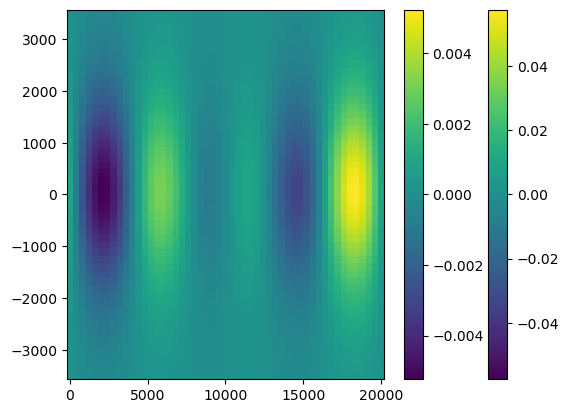

In [32]:
xx,yy = np.meshgrid(fieldsetBJ3D.U.grid.lon,fieldsetBJ3D.U.grid.lat)
cb = plt.pcolormesh(xx, yy, fieldsetBJ3D.V.data[0,0,:,:])
plt.colorbar(cb)

cb = plt.pcolormesh(xx, yy, fieldsetBJ3D.V.data[0,-1,:,:])
plt.colorbar(cb)

In [34]:
fieldsetBJ3D = add_uniform_temp_salt_field(fieldsetBJ3D, np.arange(0, 1.1, 0.1) * 86400)